### SSIoT traffic analysis

The notebook is designed to fit my data, but it should work for also for the other IoT device.
The pcap files should first be converted into a csv file.

In [1]:
import pandas as pd
import sys
from os import listdir
from os.path import isfile, join
import re
from matplotlib import pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans


In [92]:
path_miLamp = "C:\\Users\\Raphael\\github\\Security-Services-for-IoT\\Final-Project\\pcap\\processed\\csv-files\\"
path_smartPlug = "C:\\Users\\Raphael\\github\\Security-Services-for-IoT\\Final-Project\\pcap\\processed\\splug-csv\\"
filenames_miLamp = [f for f in listdir(path_miLamp) if isfile(join(path_miLamp, f))]
filenames_smartPlug = [f for f in listdir(path_smartPlug) if isfile(join(path_smartPlug, f))]

exclude= ["MiLampStartUp.csv", "MiLampStartUp2.csv"]

### Load files and label them accordinngly
Each csv file in the given directory, except the ones in the "exclude" variable, will be loaded and added to one dataframe. 
The labels correspond the the filename.

In [93]:
# read files and label them accordingly
def read_and_label(df, filenames,exclude, path):
    sametest = []
    checked = set()
    for file in filenames:
        if file in exclude:
            continue
        same = []
        file = file.split(".")[0]
        for name in filenames:
            if file in name and file != name:
                if name not in checked:
                    #name = name.split(".")[0]
                    same.append(name)
                    checked.add(name)
        if len(same) > 0:
            sametest.append(same)
    df = pd.DataFrame()
    for files in sametest:
        tm = pd.DataFrame()
        for i in range(len(files)):
            tm = pd.concat([tm, pd.read_csv(path + files[i], header=0)],ignore_index=False)
        tm["label"] = str(files[0].split(".")[0])
        df = pd.concat([df,tm], ignore_index=False)
    df = df.reset_index(drop=True)
    return df

### This should be changed depending on the format of the timestamp

In [94]:
# reformat the timestamp
def recode_time(df):
    for i in range(df.shape[0]):
        date = str(df.at[i,"frame.time"]).split(" ")
        if len(date) == 7:
            df.at[i,"frame.time"] = pd.Timestamp(str(df.at[i,"frame.time"]).split(" ")[4])
        else:
            df.at[i,"frame.time"] = pd.Timestamp(str(df.at[i,"frame.time"]).split(" ")[3])

In [110]:
# plots every feature of the given df, except the excluded ones, m are rows and n are the columns of the plot
def plot_stuff(df, exclude,m,n):
    c = 0
    r = 0
    fig, axs = plt.subplots(m,n, sharex=False, figsize=(30,12))
    for column in df:
        if column in exclude:
            continue
        axs[r, c%n] = df[column].value_counts().plot(kind="barh", ax=axs[r, c%n], title=column)
        #axs[r, c%n].set_title(column)
        # set individual bar lables using above list
        for i in axs[r, c%n].patches:
            # get_width pulls left or right; get_y pushes up or down
            axs[r, c%n].text(i.get_width()+.1, i.get_y()+.2, str(round((i.get_width()), 2)), fontsize=10, color='dimgrey')
        c += 1 
        r += n == c /(r + 1)
    plt.show()
    plt.clf
    print("Info for ip protocol: 2:{}, 6: {}, 17: {}".format("IGMP (Internet Group Management Protocol)", "TCP", "UDP"))

In [96]:
df_ml = read_and_label(df_ml,filenames_miLamp, exclude, path_miLamp)
df_sp = read_and_label(df_sp,filenames_smartPlug, [], path_smartPlug)
recode_time(df_ml)

In [98]:
# show available labels for MiLamp:
df_ml.label.value_counts()

MiLampDecreaseBrightnessInApp    282
MiLampIncreaseTempInApp          229
MiLampDecreaseTempInApp          196
MiLampIncreaseBrightnessInApp    181
MiLampChildMode                   65
MiLampPushTurnButtonLeft          52
MiLampAdjustTempInApp             41
MiLampTurnButtonLeft              41
MiLampTurnButtonRight             36
MiLampTurnOnFocusModeApp          30
MiLampPushTurnButtonRight         27
MiLampDoubleTabButton             26
MiLampAdjustBrightnessInApp       24
MiLampOpenApp                     20
MiLampTurnOnPCModeApp             15
MiLampTurnOffinApp                15
MiLampTurnOninApp                 15
MiLampTurnOffFocusModeApp         14
MiLampTurnOnReadingModeApp        13
MiLampPressOnButtonToTurnOn       13
MiLampOpenSettings                11
MiLampPressOnButtonToTurnOff      10
Name: label, dtype: int64

In [100]:
# show available labels for SmartPlug:
df_sp.label.value_counts()

test_on_off_using_wifi                           852
plug_device                                      240
whole_interaction_on_off_setti_sch_tim_aw_run    233
turn_of                                          233
turn_on                                          197
leave_1_min_the_page_device                      155
leave_the_app_open_with_no_action                124
enter_to_the_app                                  57
set_off_away_mode                                 52
press_wifi_button                                 47
press_turn_off                                    45
go_to_settings_device                             44
create_schedule                                   40
set_away_mode                                     37
add_event                                         32
enter_to_the_device_from_app                      25
enter_to_run_time                                 24
press_turn_on                                     19
Name: label, dtype: int64

In [113]:
df_sp.head()

,frame.number,frame.time,eth.src,eth.dst,ip.src,ip.dst,ip.proto,data.data,data.len,udp.srcport,udp.dstport,udp.length,eth.addr.oui_resolved,tcp.srcport,tcp.dstport,tcp.len,label
0,1,"Jun 8, 2020 09:31:56.346016000 Mitteleuropäis...",98:0d:67:33:29:70,d0:37:45:53:9a:9d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Tp-Link Technologies Co.,Ltd.",NaN,NaN,NaN,add_event
1,2,"Jun 8, 2020 09:31:56.346075000 Mitteleuropäis...",d0:37:45:53:9a:9d,98:0d:67:33:29:70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Zyxel Communications Corporation,NaN,NaN,NaN,add_event
2,3,"Jun 8, 2020 09:31:56.865552000 Mitteleuropäis...",98:0d:67:33:29:70,ff:ff:ff:ff:ff:ff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Zyxel Communications Corporation,NaN,NaN,NaN,add_event
3,4,"Jun 8, 2020 09:31:57.320347000 Mitteleuropäis...",d0:37:45:53:9a:9d,98:0d:67:33:29:70,192.168.1.182,192.168.1.1,17.0,NaN,NaN,53185.0,53.0,50.0,Zyxel Communications Corporation,NaN,NaN,NaN,add_event
4,5,"Jun 8, 2020 09:31:57.320563000 Mitteleuropäis...",d0:37:45:53:9a:9d,98:0d:67:33:29:70,192.168.1.182,192.168.1.1,17.0,NaN,NaN,53185.0,53.0,52.0,Zyxel Communications Corporation,NaN,NaN,NaN,add_event


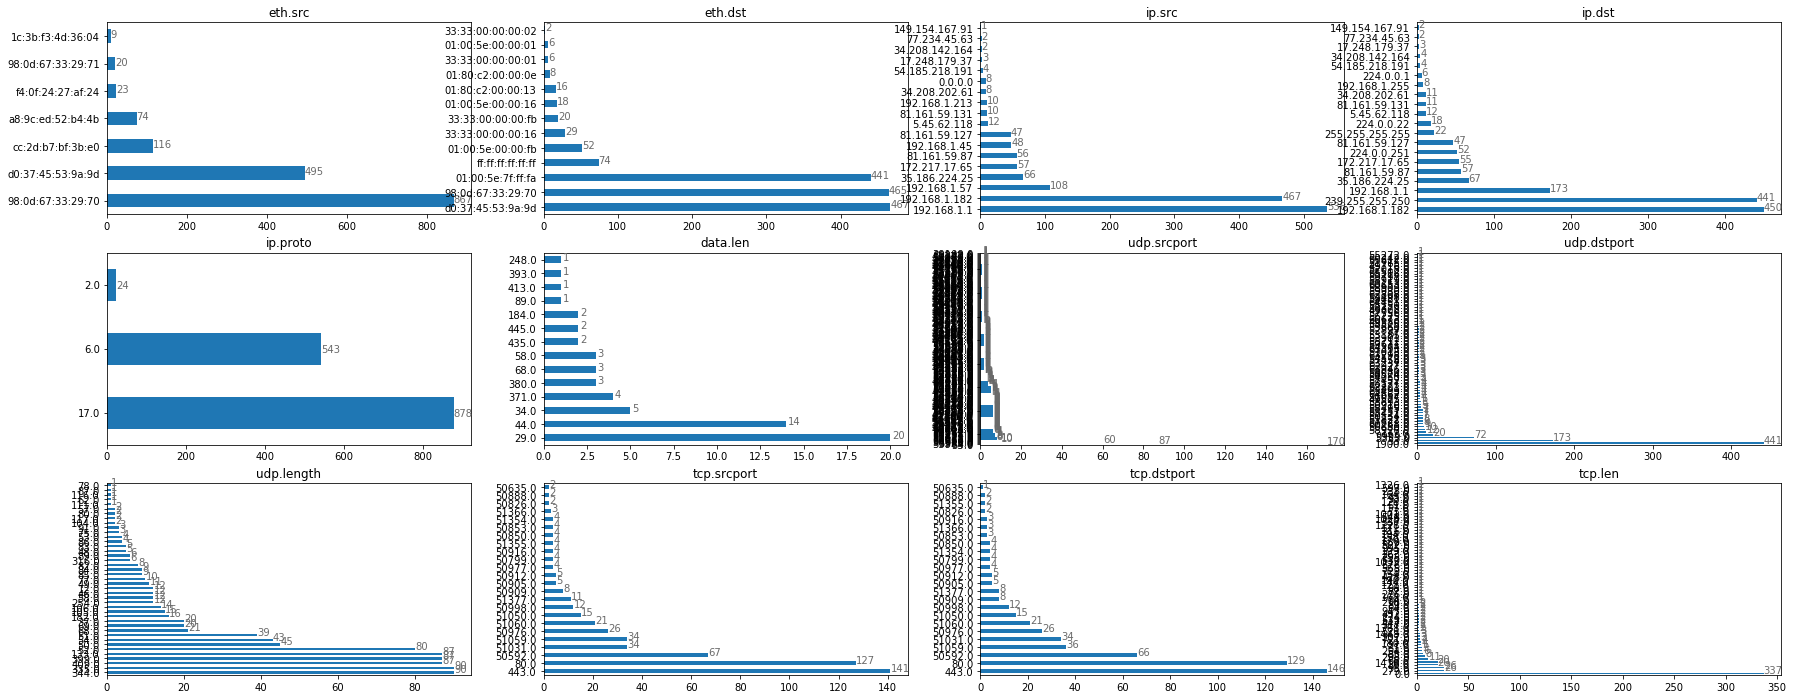

Info for ip protocol: 2:IGMP (Internet Group Management Protocol), 6: TCP, 17: UDP


In [111]:
no_interest = ["frame.number", "frame.time","data.data", "eth.addr.oui_resolved", "label"]
plot_stuff(df_sp,no_interest,3,4)

IndexError: index 3 is out of bounds for axis 0 with size 3

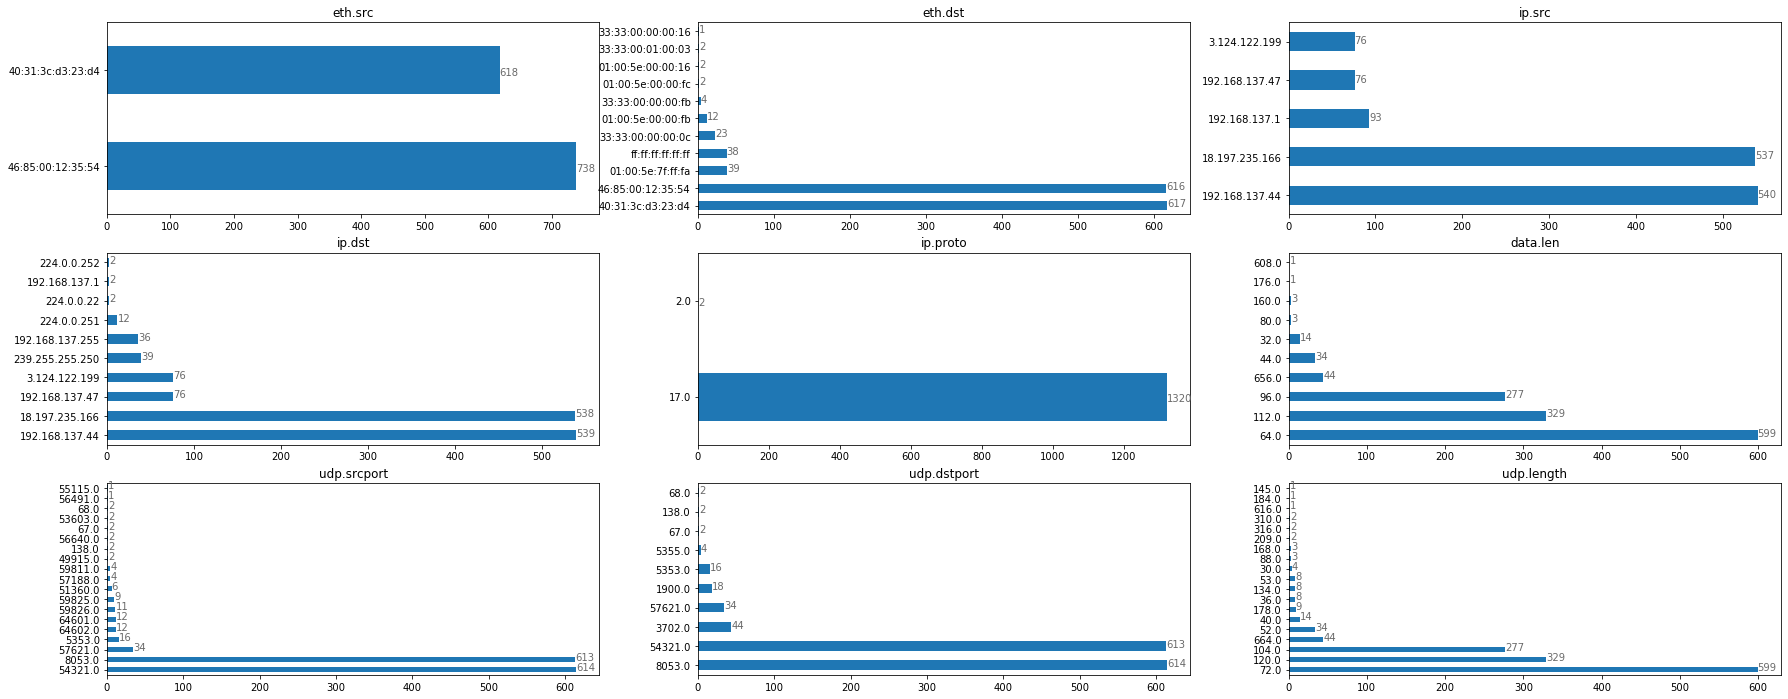

In [112]:
plot_stuff(df_ml,no_interest,3,3)

In [60]:
#select specific test/label
x1 = df.loc[df.label == "MiLampDecreaseBrightnessInApp"]

In my measurements, sometimes there is still irrelevant traffic. With the followong function you can delete specific rows.

In [66]:
# drop specific rows
# columns: the feature where the unwanted value occurs
# values: the unwanted value
def drop_it(df, column, value):
    df = df.drop(df[df[column] == value].index)
    return df

In [67]:
# drop traffic from "192.168.137.1"
x1 = drop_it(x1,"ip.src", "192.168.137.1")
x1.head()

,frame.number,frame.time,eth.src,eth.dst,ip.src,ip.dst,ip.proto,data.data,data.len,udp.srcport,udp.dstport,udp.length,eth.addr.oui_resolved,label
130,1,2020-06-15 10:20:44.582493,46:85:00:12:35:54,40:31:3c:d3:23:d4,18.197.235.166,192.168.137.44,17.0,21310070000000000721ae555ee5ddda1f2eecdc1f23e5...,112.0,8053.0,54321.0,120.0,"XIAOMI Electronics,CO.,LTD",MiLampDecreaseBrightnessInApp
131,2,2020-06-15 10:20:44.752658,40:31:3c:d3:23:d4,46:85:00:12:35:54,192.168.137.44,18.197.235.166,17.0,21310040000000000721ae555ee5dddaab4a50bc703085...,64.0,54321.0,8053.0,72.0,"XIAOMI Electronics,CO.,LTD",MiLampDecreaseBrightnessInApp
132,3,2020-06-15 10:20:44.755314,40:31:3c:d3:23:d4,46:85:00:12:35:54,192.168.137.44,18.197.235.166,17.0,21310060000000000721ae555ee5ddda613b63df8adf36...,96.0,54321.0,8053.0,104.0,"XIAOMI Electronics,CO.,LTD",MiLampDecreaseBrightnessInApp
133,4,2020-06-15 10:20:44.789079,46:85:00:12:35:54,40:31:3c:d3:23:d4,18.197.235.166,192.168.137.44,17.0,21310040000000000721ae555ee5ddda7fd3210a46cecb...,64.0,8053.0,54321.0,72.0,"XIAOMI Electronics,CO.,LTD",MiLampDecreaseBrightnessInApp
134,5,2020-06-15 10:20:45.086023,46:85:00:12:35:54,40:31:3c:d3:23:d4,18.197.235.166,192.168.137.44,17.0,21310070000000000721ae555ee5dddacc9a653bde272a...,112.0,8053.0,54321.0,120.0,"XIAOMI Electronics,CO.,LTD",MiLampDecreaseBrightnessInApp


In [68]:
no_interest = ["frame.number", "frame.time","data.data", "eth.addr.oui_resolved", "label"]

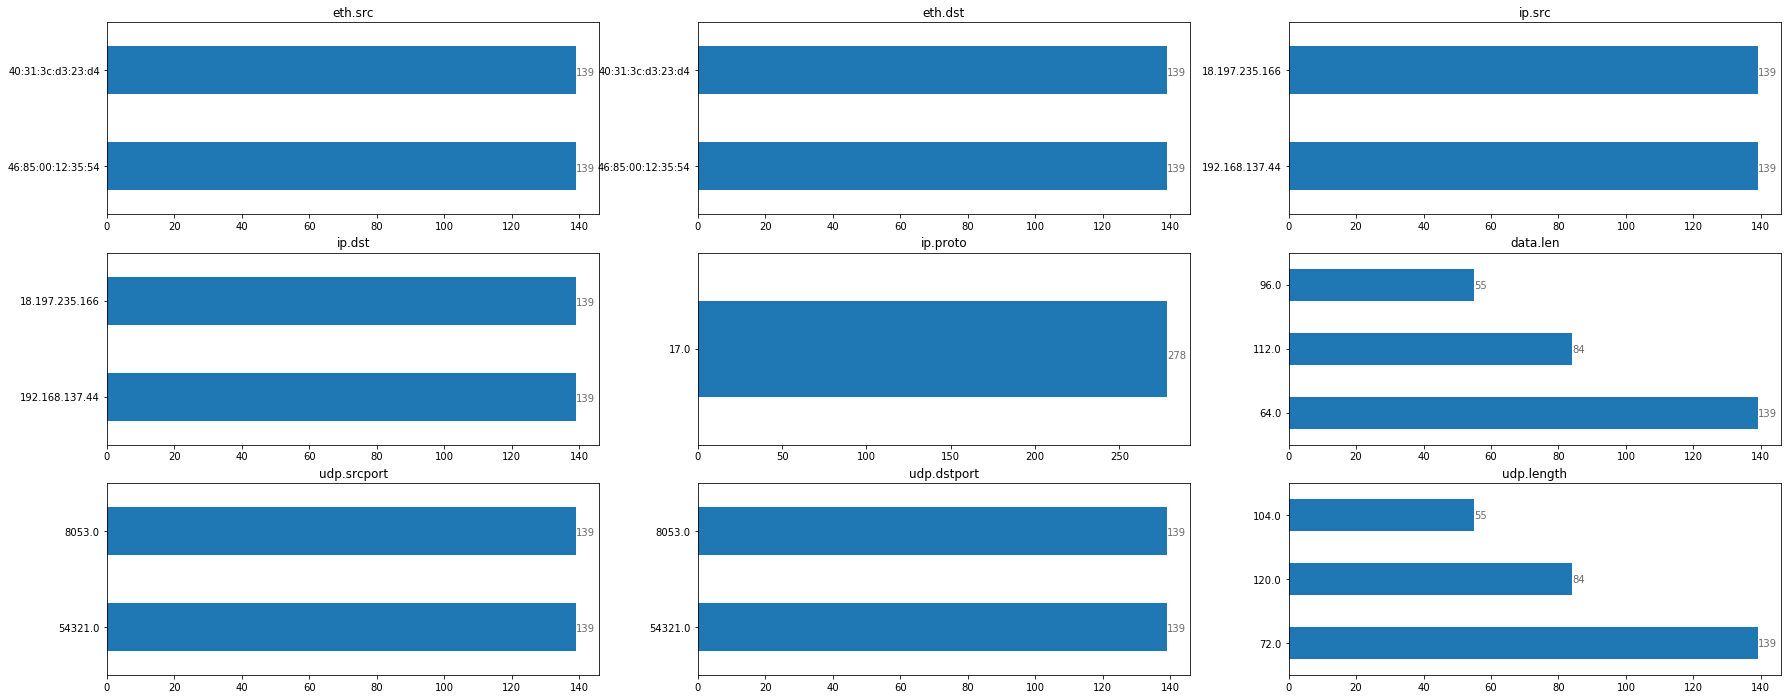

<Figure size 432x288 with 0 Axes>

In [69]:
plot_stuff(x1,no_interest,3,3)

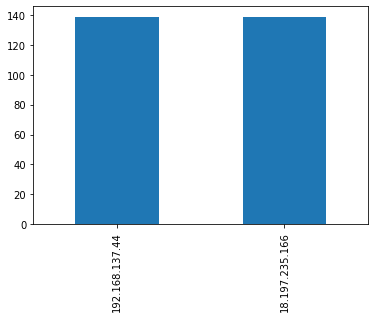

In [91]:
print(filenames_miLamp)

['MiLampAdjustBrightnessInApp.csv', 'MiLampAdjustTempInApp.csv', 'MiLampChildMode.csv', 'MiLampChildMode2.csv', 'MiLampChildMode3.csv', 'MiLampChildModeOff.csv', 'MiLampChildModeOff2.csv', 'MiLampChildModeOff3.csv', 'MiLampChildModeOn4.csv', 'MiLampDecreaseBrightnessInApp.csv', 'MiLampDecreaseBrightnessInApp2.csv', 'MiLampDecreaseBrightnessInApp3.csv', 'MiLampDecreaseTempInApp.csv', 'MiLampDecreaseTempInApp2.csv', 'MiLampDecreaseTempInApp3.csv', 'MiLampDoubleTabButton.csv', 'MiLampDoubleTabButton2.csv', 'MiLampDoubleTabButton3.csv', 'MiLampIncreaseBrightnessInApp.csv', 'MiLampIncreaseBrightnessInApp2.csv', 'MiLampIncreaseBrightnessInApp3.csv', 'MiLampIncreaseTempInApp.csv', 'MiLampIncreaseTempInApp2.csv', 'MiLampIncreaseTempInApp3.csv', 'MiLampOpenApp.csv', 'MiLampOpenApp2.csv', 'MiLampOpenApp3.csv', 'MiLampOpenSettings.csv', 'MiLampOpenSettings2.csv', 'MiLampOpenSettings3.csv', 'MiLampPressOnButtonToTurnOff.csv', 'MiLampPressOnButtonToTurnOff2.csv', 'MiLampPressOnButtonToTurnOff3.csv'

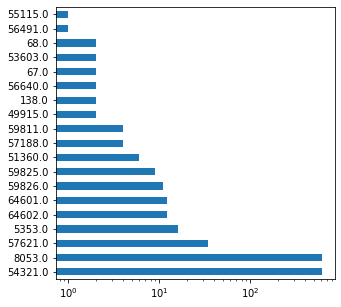

In [12]:
df["udp.srcport"].value_counts().plot(kind="barh", figsize=(5,5), logx=True)

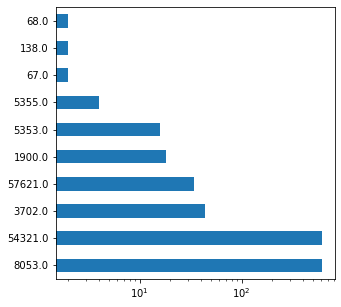

In [13]:
df["udp.dstport"].value_counts().plot(kind="barh", figsize=(5,5), logx=True)

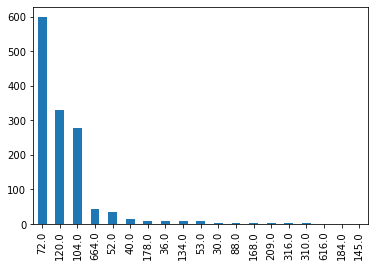

In [14]:
df["udp.length"].value_counts().plot(kind="bar")

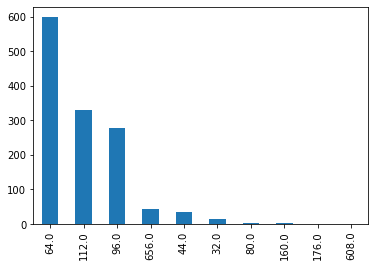

In [15]:
df["data.len"].value_counts().plot(kind="bar")

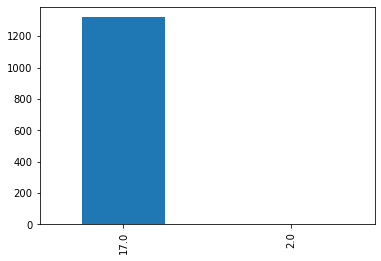

In [18]:
df["ip.proto"].value_counts().plot(kind="bar")

In [79]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier


In [112]:
x = df.drop(columns=["frame.number", 'eth.addr.oui_resolved', "frame.time", "ip.proto"])
x = x.fillna("0")
#Function to encode given features
# input df: dataframe which should be modified
# input features: features that should be encoded
def encode_feature(df, feature):
  feature_enc = LabelEncoder()
  feature_enc.fit(df[feature].to_numpy().astype(str))
  df[feature] = feature_enc.transform(df[feature])

features = ["eth.src", "eth.dst", "ip.src", "ip.dst", "label", "data.data"]

for feat in features:
    encode_feature(x,feat)
y = x["label"]
x = x.drop(columns=["label"])
#x=x["data.data"]
x = x.reset_index(drop=True)

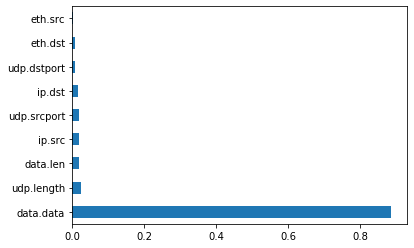

In [113]:
# Show the relevance of each feature
model = ExtraTreesClassifier()
model.fit(x,y.astype('int').ravel())
# visualize the importance of the features
imp_features = pd.Series(model.feature_importances_, index=x.columns)
imp_features.nlargest(len(x.columns.tolist())).plot(kind='barh')
plt.show()

In [114]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [115]:
# set up the classifier
# white-box classifier
model_wb = KNeighborsClassifier(n_neighbors=3).fit(X_train,y_train)

prob_wb = model_wb.predict_proba(X_train)
print(model_wb.score(X_test,y_test))

# train black-box
model_bb = ComplementNB().fit(X_train,y_train)
prob_bb = model_bb.predict_proba(X_train)

print(model_bb.score(X_test,y_test))

0.796875
0.1875
